In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize for three channels
])

# Load CIFAR-10 dataset
cifar10_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar10_testset = datasets.CIFAR10(root='./data', train=False, transform=transform)


/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <E03EDA44-89AE-3115-9796-62BA9E0E2EDE> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <F2FE5CF8-5B5B-3FAD-ADF8-C77D90F49FC9> /Users/chrispark/anaconda3/lib/python3.11/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Files already downloaded and verified


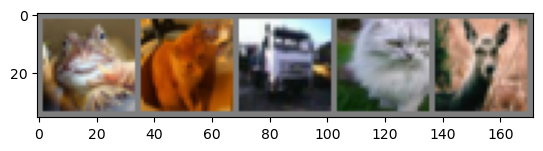

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(DataLoader(cifar10_trainset, batch_size=5, shuffle=True))
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))


In [4]:
# Splitting the dataset
train_size = int(0.9 * len(cifar10_trainset))
val_size = len(cifar10_trainset) - train_size
cifar10_train, cifar10_val = random_split(cifar10_trainset, [train_size, val_size])

# Creating data loaders
train_loader = DataLoader(cifar10_train, batch_size=32, shuffle=True)
val_loader = DataLoader(cifar10_val, batch_size=32, shuffle=False)


In [11]:
import torch.nn as nn
import torch.nn.functional as F

class SimVGG16(nn.Module):
    def __init__(self):
        super(SimVGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(32 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimVGG16()


Epoch 1 training loss: 1.565524220974969
Epoch 1 validation loss: 1.2172203918171536
Epoch 2 training loss: 1.1710095000588987
Epoch 2 validation loss: 1.0850328989089675
Epoch 3 training loss: 1.0185932573394396
Epoch 3 validation loss: 0.9805446343057475
Epoch 4 training loss: 0.9217099733571253
Epoch 4 validation loss: 0.9522126182249397
Epoch 5 training loss: 0.8495766233491322
Epoch 5 validation loss: 0.9116381570032448
Epoch 6 training loss: 0.7913459742967338
Epoch 6 validation loss: 0.8850166419888758
Epoch 7 training loss: 0.7331763180376539
Epoch 7 validation loss: 0.8568911347419593
Epoch 8 training loss: 0.6842329443856682
Epoch 8 validation loss: 0.8547194750066016
Epoch 9 training loss: 0.6493404482113357
Epoch 9 validation loss: 0.8616345595022675
Epoch 10 training loss: 0.6101995745002587
Epoch 10 validation loss: 0.8602682179326464
Epoch 11 training loss: 0.5769959304484392
Epoch 11 validation loss: 0.9170573889070256
Epoch 12 training loss: 0.5523574253399912
Epoch 12

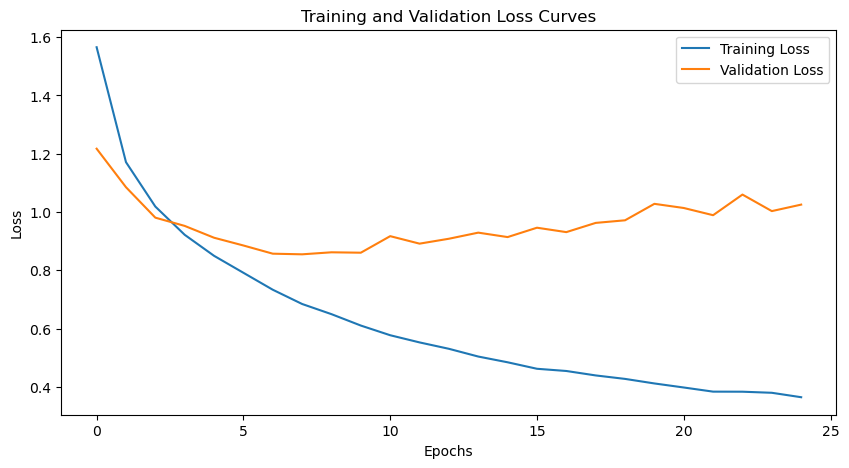

In [12]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Set up optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Initialize lists to track the losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(25):  
    running_loss = 0.0
    model.train()  # Set model to training mode
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Record training loss
    train_losses.append(running_loss / len(train_loader))
    print(f'Epoch {epoch + 1} training loss: {running_loss / len(train_loader)}')

    # Validation phase
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Record validation loss
    val_losses.append(val_loss / len(val_loader))
    print(f'Epoch {epoch + 1} validation loss: {val_loss / len(val_loader)}')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
# Evaluate accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation images: {100 * correct / total}%')

# Predict on the test set
test_loader = DataLoader(cifar10_testset, batch_size=32, shuffle=False)
predictions = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.tolist())

print(predictions[:10])  # Print the first 10 predictions


Accuracy of the network on the validation images: 71.26%
[3, 8, 8, 0, 6, 6, 1, 4, 3, 1]
